# Example how to use Paituli STAC with Python

This example shows how to use [Paituli STAC catalogue](https://paituli.csc.fi/geoserver/ogc/stac/v1) with Python.  

This workflow is meant for processing big raster datasets, also with good support for time series. The main idea is to first define the search and processing as process graph. The downloading and processing is done lazily at the end, so that only needed data (good enough cloud-free image, only needed bands and area) is downloaded. The libraries take care of data download, so you do not need to know about file paths. These tools work best when data is provided as [Cloud-optimized GeoTiffs](https://www.cogeo.org/) (COGs).

Dask is used for parallelization of computing, see [CSC Dask tutorial](https://docs.csc.fi/support/tutorials/dask-python/), inc how to use Dask with Jupyter in Puhti web interface and how to create batch jobs with Dask.

The main steps:
* Start Dask cluster
* Query STAC catalogue to find images from area and time of interest and small cloud coverage, 
* Create first datacube, defining required bands and bbox.
* Mosaic the images with median value, for each month.
* Plot images
* Calculate monthly NDVI-index
* Save the NDVI-index to GeoTiff file.
* Close Dask cluster

At the end of the Notebook additionally is shown how to open files from STAC results with Rasterio.

The example is based on:
* [Stackstac documentation](https://stackstac.readthedocs.io/en/latest/basic.html),
* Stacspec.org, Tutorials, [Access Sentinel 2 Data from AWS plotting](https://stacspec.org/en/tutorials/access-sentinel-2-data-aws)

## Preparations

In [1]:
import stackstac
from dask.distributed import Client, Lock
import pystac_client
import pyproj
import geopandas as gpd
import json
import os
import rioxarray
import xarray as xr
import numpy as np

If you want to see pystac_client API calls, set logger to DEBUG. Enable if you want.

In [2]:
# import logging
# logging.basicConfig()
# logger = logging.getLogger('pystac_client')
# logger.setLevel(logging.DEBUG)

### Start Dask cluster

Dask cluster is needed for automatic parallization of the data processing. It is not needed for searching STAC or processing smaller datasets.
For following how Dask works open [Dask Dashboard or JupyterLab Dask Extension](https://docs.csc.fi/support/tutorials/dask-python/#dask-with-jupyter).

In [2]:
# Hard-coded number of workers for STAC workshop in Noppe
no_of_workers = 1
## Normally use this, inc. for supercomputers with batch jobs
## no_of_workers = len(os.sched_getaffinity(0))
client = Client(n_workers=no_of_workers)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 3.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41245,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 3.00 GiB
Comm: tcp://127.0.0.1:33135,Total threads: 8
Dashboard: http://127.0.0.1:34801/status,Memory: 3.00 GiB
Nanny: tcp://127.0.0.1:41715,


### Define STAC endpoint

For using a specific STAC API, its endpoint must be defined.

Open the catalog description from the small black triangle, after running the cell.

In [ ]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
catalog

See basic info about the STAC catalog

In [4]:
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")

Title: Paituli STAC
Description: Paituli STAC with Finnish data. More info: https://paituli.csc.fi/stac.html


Which collections are available?

In [5]:
collections_list = [(collection.title, collection.id) for collection in catalog.get_collections()]
collections_list.sort()
for collection in collections_list:
    print(collection[0] + ': ' + collection[1])

Basic map, background colour, 1:20 000 (Paituli): nls_basic_map_background_colour_at_paituli
Basic map, print colour, 1:20 000 (Paituli): nls_basic_map_print_colour_at_paituli
Basic map, without contours, 1:20 000 (Paituli): nls_basic_map_without_contours_at_paituli
Basic or topographic map, 1:100 000 (Paituli): nls_topographic_map_100k_at_paituli
Basic or topographic map, 1:20 000 (Paituli): nls_topographic_map_20k_at_paituli
Basic or topographic map, 1:25 000 (Paituli): nls_topographic_map_25k_at_paituli
Basic or topographic map, 1:50 000 (Paituli): nls_topographic_map_50k_at_paituli
Biomass, broad-leaved trees, dead branches (Paituli): luke_vmi_bm_lehtip_kuolleetoksat_at_paituli
Biomass, broad-leaved trees, foliage (Paituli): luke_vmi_bm_lehtip_neulaset_at_paituli
Biomass, broad-leaved trees, living branches (Paituli): luke_vmi_bm_lehtip_elavatoksat_at_paituli
Biomass, broad-leaved trees, roots (Paituli): luke_vmi_bm_lehtip_juuret_at_paituli
Biomass, broad-leaved trees, stem and bar

Get collection's metadata. Use **collection ID** for search here and later. In this example we use:

* Sentinel-2 11-days surface reflectance mosaics (FMI Tuulituhohaukka): **sentinel_2_11_days_mosaics_at_fmi**
* Sentinel-2 L2A: **sentinel2-l2a** (original data as provided by ESA).

Find out:
* What bands are provided?
* For which time period the data is available?
* Who has created the mosaics?
* Who has downloaded ESA data to CSC Allas?

In [ ]:
collection = catalog.get_collection('sentinel_2_11_days_mosaics_at_fmi')
collection

In [ ]:
collection = catalog.get_collection('sentinel2-l2a')
collection

## Search

STAC provides two different search options:

* Basic search, available criteria: collection, location and time. 
* Advanced search with filter, basic search + other attributes provided by STAC. In Paituli STAC catalog only `sentinel2-l2a` collection has other attributes - cloud coverage.

Location can be given as point, bbox or polygon. STAC metadata is always in WGS-84 projection, so location must also be defined in WGS-84 coordinates.

In [8]:
# Define the center of area of interest
#lon, lat = 24.945, 60.173, #Helsinki
#lon, lat = 27.65, 62.88 #Kuopio
lon, lat = 28.2, 63.62 #Tiilikkajärvi

### Basic search

Search with a **point** as location.

In [9]:
%%time
search = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2021-08-01/2021-09-30"
)
print('Found items: ' "{}".format(search.matched()))

Found items: 6
CPU times: user 5.05 ms, sys: 998 μs, total: 6.05 ms
Wall time: 147 ms


Search with a **bbox** as location

In [10]:
%%time
search_bbox = catalog.search(
    bbox=[23.0,60.5,26.0,64.0],
    collections=["sentinel2-l2a"],
    datetime="2021-07-01/2021-08-15"
)
print('Found items: ' "{}".format(search_bbox.matched()))

Found items: 593
CPU times: user 4.31 ms, sys: 2.15 ms, total: 6.46 ms
Wall time: 132 ms


### Search with filter 

Search with point and **cloud coverage limit**.

In [11]:
params = {
    "intersects": {"type": "Point", "coordinates": [lon, lat]},
    "collections": "sentinel2-l2a",
    "datetime": "2021-08-01/2021-09-30",
    "filter": {
        "op": "<",
        "args": [{"property": "eo:cloud_cover"}, 20]
    }
}

search_filter = catalog.search(**params)
print('Found items: ' "{}".format(search_filter.matched()))

Found items: 6


### ItemCollection

Get ItemCollection of the search results, it includes metadata about the found scenes, and links to their data. No actual data is downloaded yet. See how Jupyter displays the ItemCollection info.

In [ ]:
item_collection = search.item_collection()
item_collection

## Plotting search results

Convert ItemCollection to GeoPandas dataframe, for plotting.

In [13]:
# ItemCollection as GeoJson 
stac_json = search_bbox.item_collection_as_dict()

# Add Item ID to properties to have access to it in GeoPandas
for a in stac_json['features']:
    a['properties']['title']=a['id']

# GeoJson as GeoPandas dataframe
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
print('Found items: ' "{}".format(len(gdf))) 

Found items: 593


See a few first items, that everything look ok.

In [14]:
gdf.head()

,geometry,datetime,proj:epsg,eo:cloud_cover,title
0,"POLYGON ((23.05056 60.33378, 23.05056 61.33444...",2021-08-15T00:00:00.000+00:00,32634,81,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEN_2...
1,"POLYGON ((23.11116 61.23068, 23.11116 62.23177...",2021-08-15T00:00:00.000+00:00,32634,69,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEP_2...
2,"POLYGON ((23.17602 62.12798, 23.17602 63.12952...",2021-08-15T00:00:00.000+00:00,32634,49,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEQ_2...
3,"POLYGON ((24.9149 60.29441, 24.9149 61.3216, 2...",2021-08-15T00:00:00.000+00:00,32634,73,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFN_2...
4,"POLYGON ((25.03031 61.18985, 25.03031 62.21844...",2021-08-15T00:00:00.000+00:00,32634,82,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFP_2...


Plot the dataframe, use transparency to make overlaps visible.

The metadata is always in WGS-84 coordinate system, if you want to plot together with data in some other coordinate system, use [GeoPandas to_crs()-function](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html).

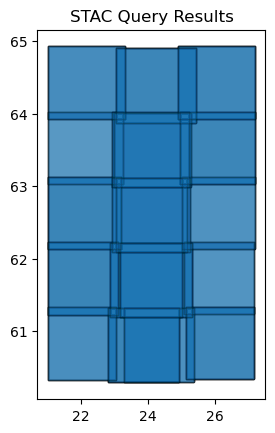

In [15]:
fig = gdf.plot(
    edgecolor="black",
    alpha=0.05,
)
_ = fig.set_title("STAC Query Results")

To plot items with a zoomable map see this example: https://stacspec.org/en/tutorials/access-sentinel-2-data-aws#Plot-STAC-Items-on-a-Map

## Retrieving data

There are two main options in Python how to use data from STAC catalog:

* Use **Xarray** to download the data as spatio-temporal datacube. It provides good support for multi-dimensional data and parallel computing. There are several libraries for creating Xarray datacubes from STAC results, so that the data in the cloud is automatically mapped and fetched.
* Use **Rasterio**, but then datacube can have only 1 dimension besides the spatial, either different bands or timesteps. Also the data URLs need to be manually handled.

### Get data to Xarray

We will use [Stackstac](https://stackstac.readthedocs.io/en) library for creating `Xarray DataArray` datacube from the STAC items. Alternatively, one could use [ODC STAC](https://odc-stac.readthedocs.io/en/latest/) or [Geowombad](https://geowombat.readthedocs.io/en/latest/index.html). There are some differences in details between the libraries, but in general they work in a similar way. See [ODC STAC discussion](https://github.com/opendatacube/odc-stac/issues/54), for differences between Stackstac and ODC STAC. 

Using the defaults, our data will be in its native coordinate reference system, at the finest resolution. But many also other values can be set here. 

* `bounds` - datacube bounds, use smaller bbox in data's UTM coordinate reference system, around the original search point and with width and height of `buffer`.
* `epsg` - datacube coordinate system, given as EPSG code.
* `chunksize` - how big part of data is analysed at once, see also [Dask chunksize](https://github.com/csc-training/geocomputing/blob/master/python/STAC/Readme.md#dask-chunksize). 
* `resolution` - pixel size
* See [stackstac.stac()](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html#stackstac.stack) documentation for more details. 

This will be fast, because the actual data is not fetched yet. How does the datacube look like? How many dimensions does it have?

In [16]:
%time 
x, y = pyproj.Proj("EPSG:3067")(lon, lat)
buffer = 3000 

cube = stackstac.stack(
    items=item_collection,
    bounds=(x-buffer, y-buffer, x+buffer, y+buffer), 
    assets=["b04", "b03", "b02", 'b08', "quality_scene_classification"],
    chunksize=(-1,1,2048,2048),
    resolution=10,
    # resampling=Resampling.bilinear
    epsg=3067
).squeeze() 
# When item_collection contains multiple epsg's, epsg value needs to be provided
cube

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.48 μs


<xarray.DataArray 'stackstac-09062fef2ad283beb1a9ed7200c1d4c3' (time: 6,
                                                                band: 5,
                                                                y: 601, x: 601)> Size: 87MB
dask.array<fetch_raster_window, shape=(6, 5, 601, 601), dtype=float64, chunksize=(6, 1, 601, 601), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 48B 2021-08-01 ... 2021-09-21
    id              (time) <U53 1kB 'Sentinel-2_global_mosaic_dekadi_2021-08-...
  * band            (band) <U28 560B 'b04' ... 'quality_scene_classification'
  * x               (x) float64 5kB 5.565e+05 5.565e+05 ... 5.625e+05 5.625e+05
  * y               (y) float64 5kB 7.058e+06 7.058e+06 ... 7.052e+06 7.052e+06
    start_datetime  (time) <U29 696B '2021-08-01T00:00:00.000+00:00' ... '202...
    proj:code       <U9 36B 'EPSG:3067'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    end_datetime    (time) <U29 696B '2021-08-10T23:59:59.000+00:00' ... '202...
    title           (band) <U28 560B 'b04' ... 'quality_scene_classification'
    epsg            int64 8B 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(556480, 7052220, 562490, 70582...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 556480.00|\n| 0.00,-10.00, 7058230.00|\n| 0.0...
    resolution:  10

Remove pixels, which do not have data (clouds etc). For older mosaics this information is given in the asset `quality_scene_classification`. For later years, similar information is stored in asset `valid_observations`.

In [17]:
sentinel_stack = xr.where((cube.sel(band="quality_scene_classification") >= 1), x = cube, y = np.nan)
sentinel_stack

<xarray.DataArray 'stackstac-09062fef2ad283beb1a9ed7200c1d4c3' (time: 6,
                                                                y: 601, x: 601,
                                                                band: 5)> Size: 87MB
dask.array<where, shape=(6, 601, 601, 5), dtype=float64, chunksize=(6, 601, 601, 1), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 48B 2021-08-01 ... 2021-09-21
    id              (time) <U53 1kB 'Sentinel-2_global_mosaic_dekadi_2021-08-...
  * band            (band) <U28 560B 'b04' ... 'quality_scene_classification'
  * x               (x) float64 5kB 5.565e+05 5.565e+05 ... 5.625e+05 5.625e+05
  * y               (y) float64 5kB 7.058e+06 7.058e+06 ... 7.052e+06 7.052e+06
    start_datetime  (time) <U29 696B '2021-08-01T00:00:00.000+00:00' ... '202...
    proj:code       <U9 36B 'EPSG:3067'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    end_datetime    (time) <U29 696B '2021-08-10T23:59:59.000+00:00' ... '202...
    epsg            int64 8B 3067

Use xarray's `resample` to create 1-month median composites. Note that we still only work on metadata/lazy-loaded data, hence we have not downloaded any data yet.

In [18]:
monthly = sentinel_stack.resample(time="MS").median("time", keep_attrs=True)
monthly

<xarray.DataArray 'stackstac-09062fef2ad283beb1a9ed7200c1d4c3' (time: 2,
                                                                y: 601, x: 601,
                                                                band: 5)> Size: 29MB
dask.array<stack, shape=(2, 601, 601, 5), dtype=float64, chunksize=(1, 601, 601, 1), chunktype=numpy.ndarray>
Coordinates:
  * band            (band) <U28 560B 'b04' ... 'quality_scene_classification'
  * x               (x) float64 5kB 5.565e+05 5.565e+05 ... 5.625e+05 5.625e+05
  * y               (y) float64 5kB 7.058e+06 7.058e+06 ... 7.052e+06 7.052e+06
    proj:code       <U9 36B 'EPSG:3067'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
  * time            (time) datetime64[ns] 16B 2021-08-01 2021-09-01

So far no data has been downloaded, nor anything computed with actual data. In this example the final data size is very small, but Dask is good also in handling much bigger amounts of data, also bigger than fits to memory.

It is also possible to [visualize, what Dask is going to do](https://docs.dask.org/en/stable/graphviz.html#). Sometimes some optimizations might be possible to make the graph better.

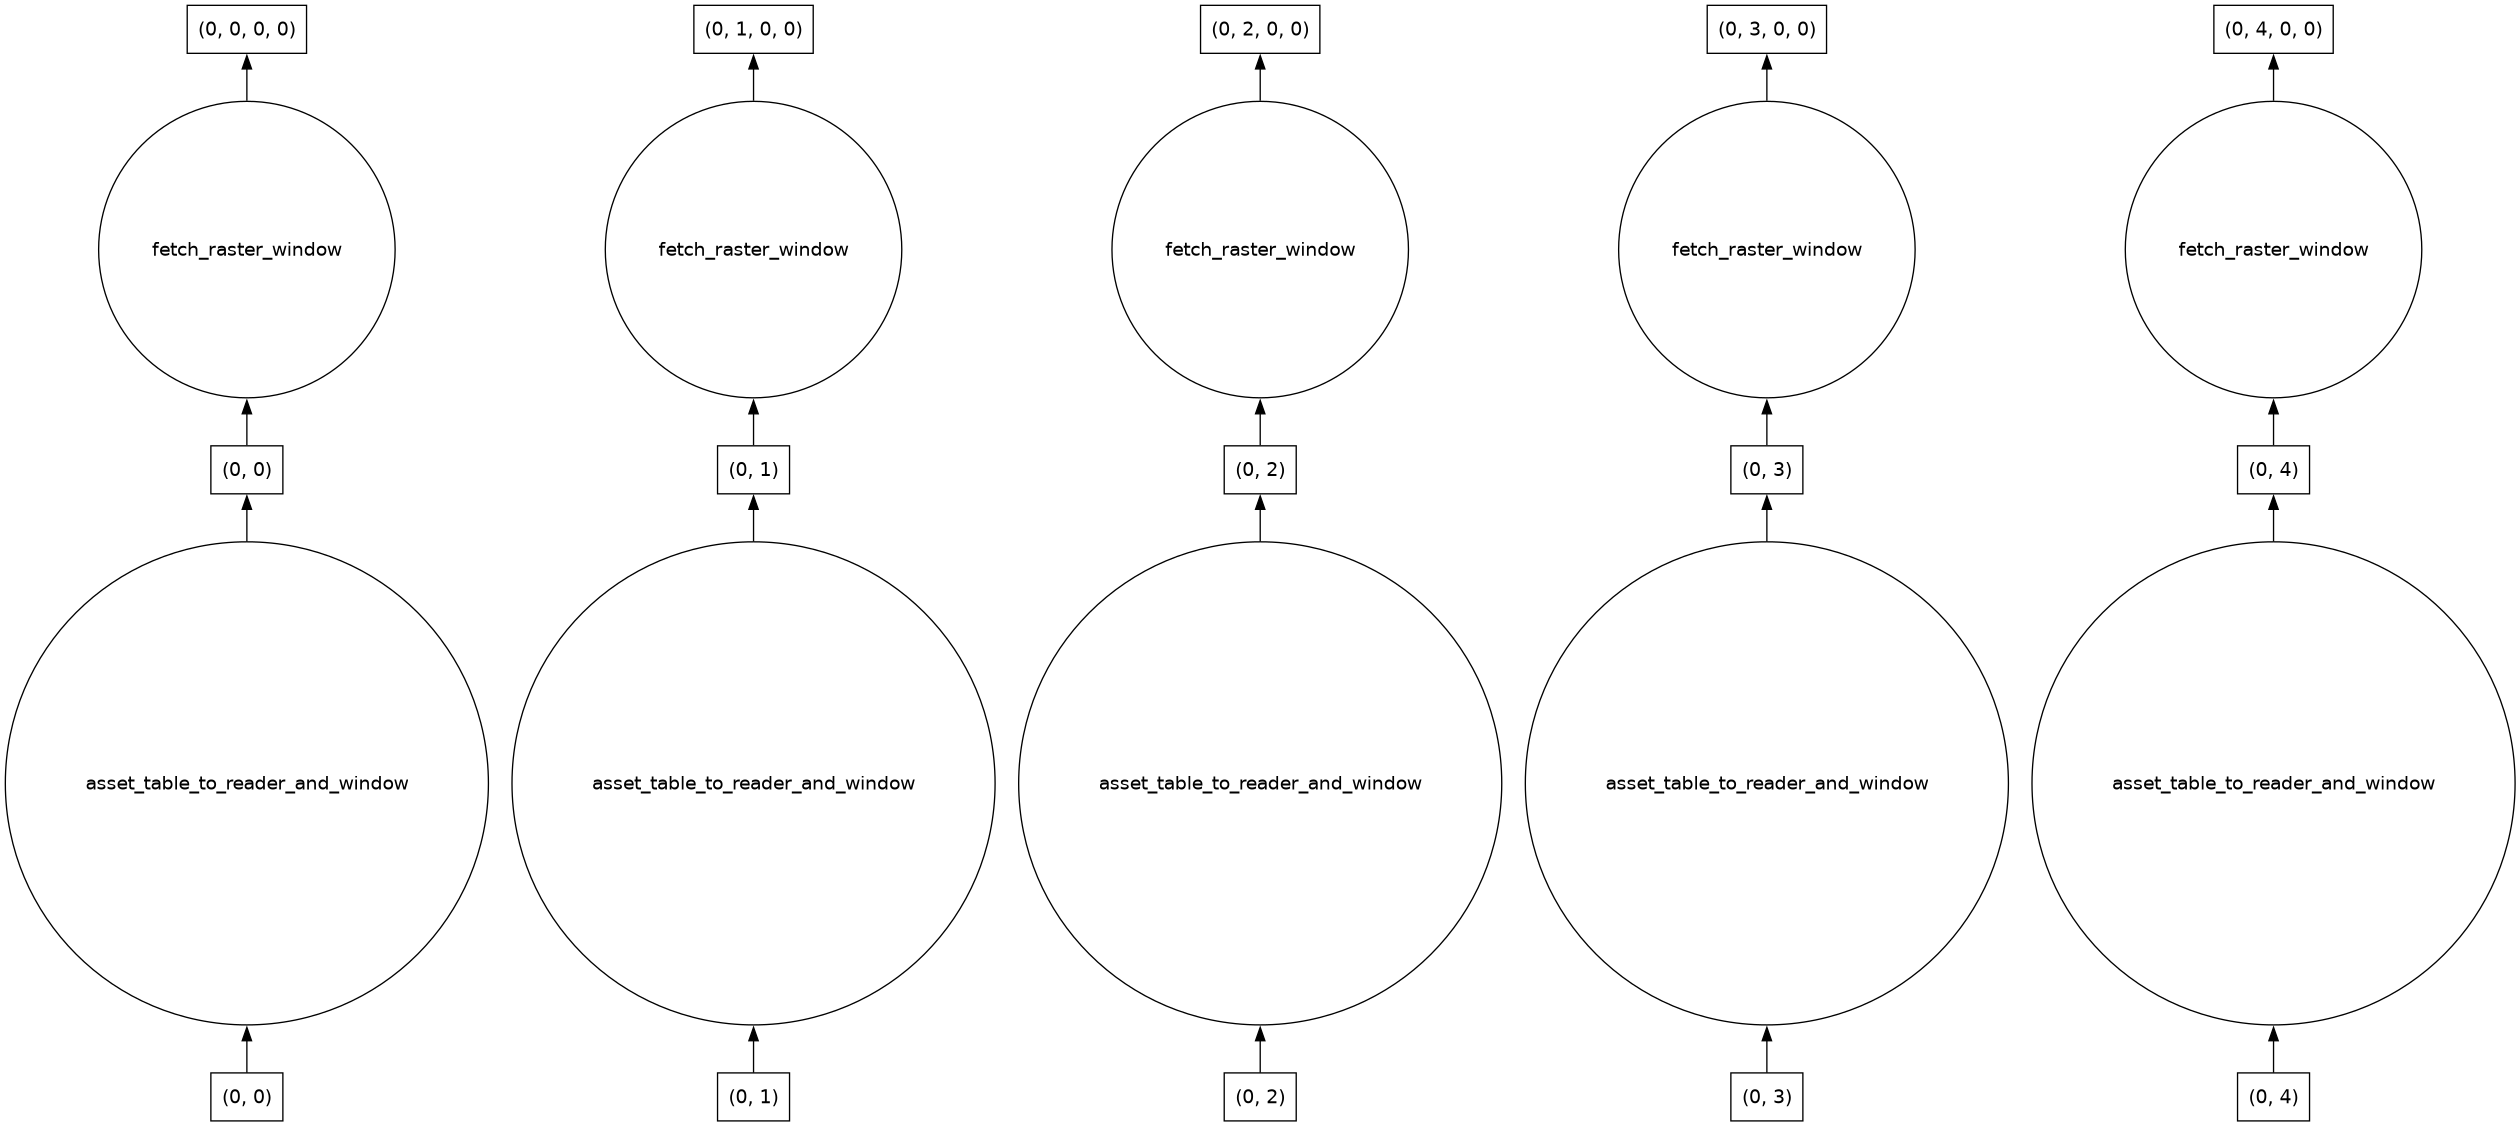

In [19]:
import dask
dask.visualize(cube)

To start the data download and analysis process `compute()` could be used, but usually it is skipped and delayed even further until saving or plotting the data. The process can be followed from Dask Dashboard or Dask Lab Extension. Depending on the amount of data, this will take some time.

In [21]:
# %%time
# data = monthly.compute()

Show the resulting images.

/opt/conda/lib/python3.12/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


CPU times: user 258 ms, sys: 62 ms, total: 320 ms
Wall time: 2.38 s


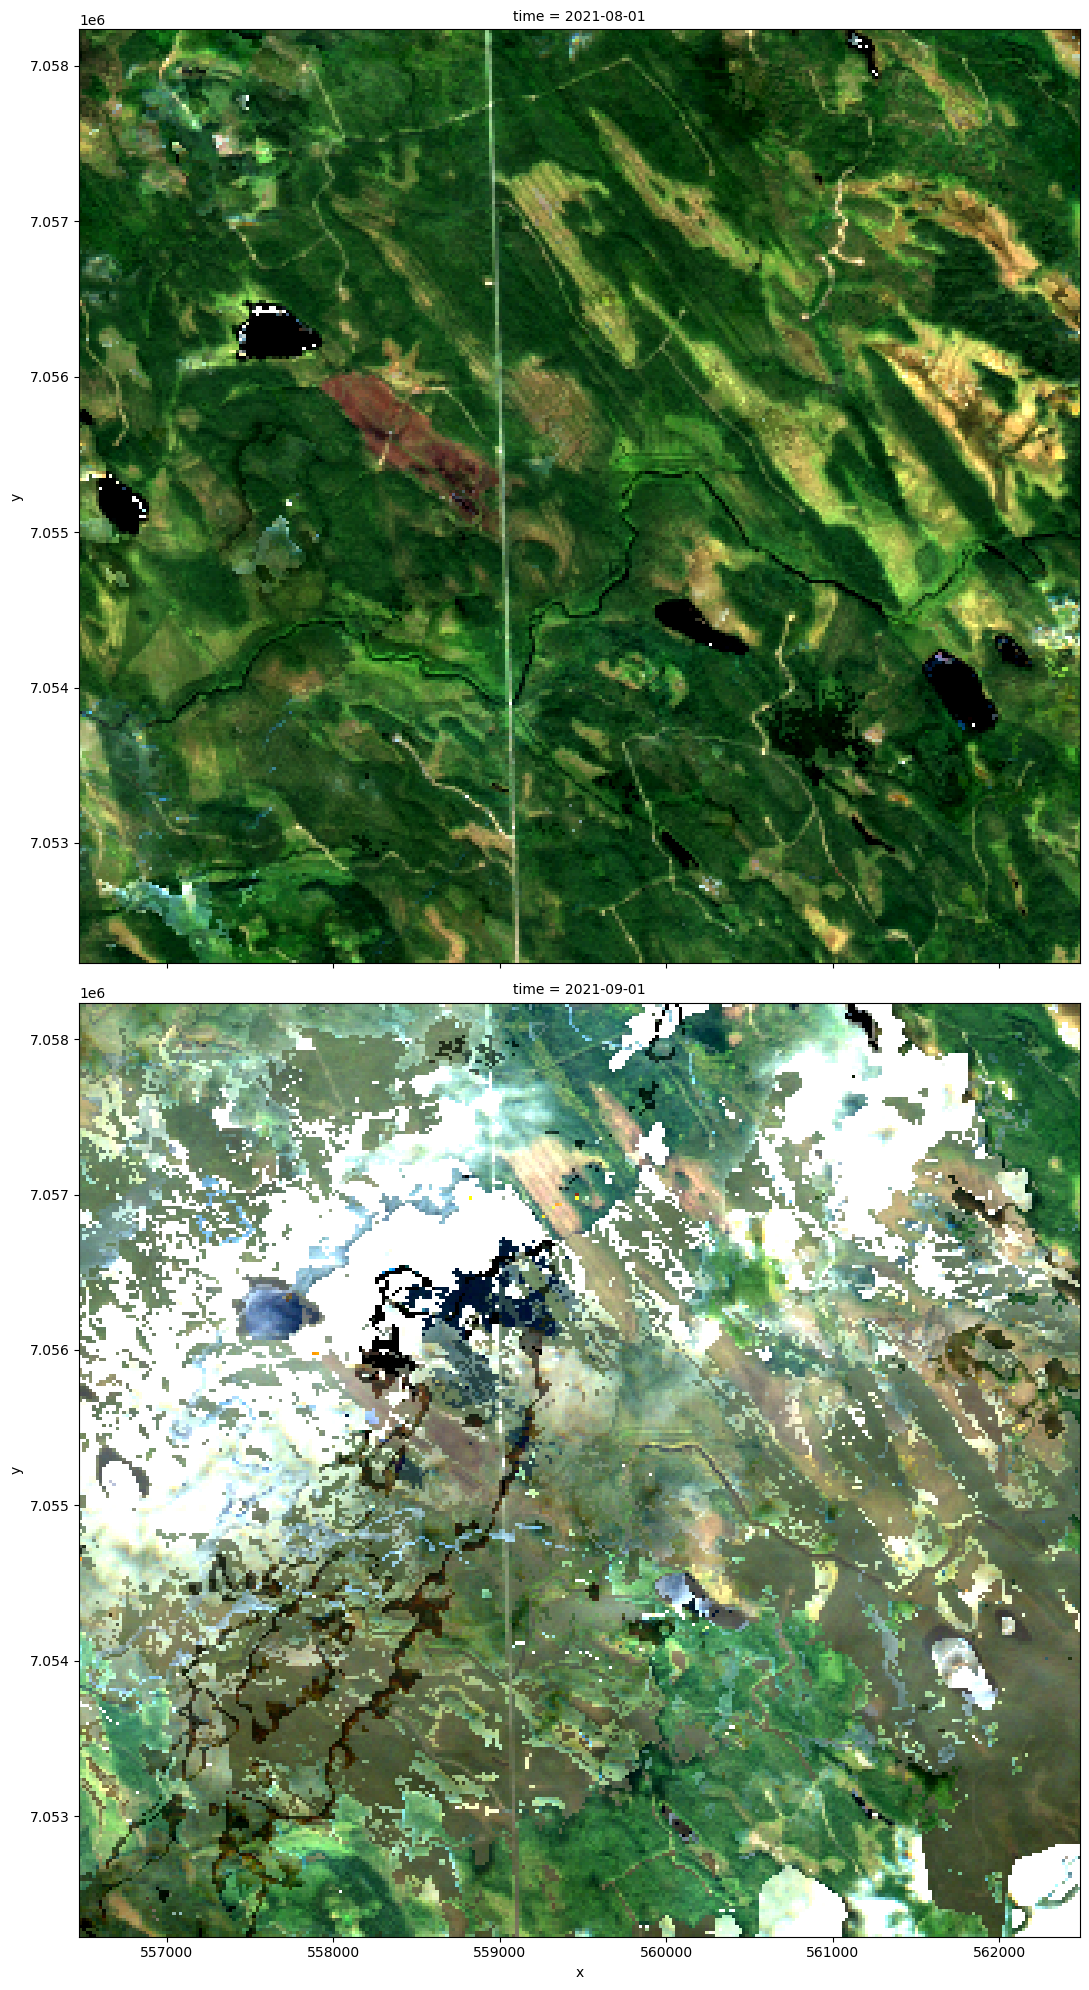

In [20]:
%%time
monthly.sel(band=["b04", "b03", "b02"]).plot.imshow(row="time", rgb="band", robust=True, size=10);

CPU times: user 163 ms, sys: 16.8 ms, total: 180 ms
Wall time: 680 ms


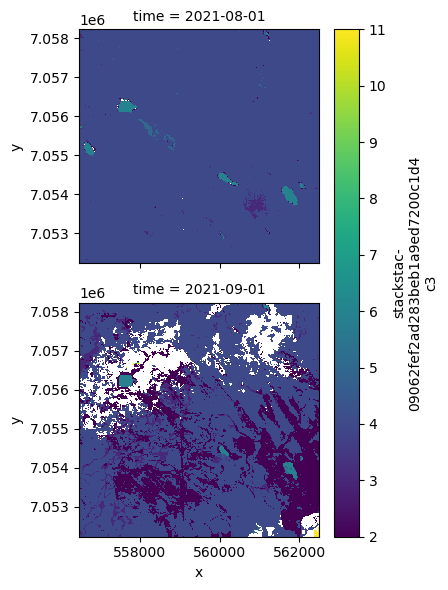

In [21]:
%%time
monthly.sel(band="quality_scene_classification").plot(row="time")

Caclulate NDVI-index of red and infrared band.

In [22]:
ndvi = (monthly.sel(band="b08") - monthly.sel(band="b04"))/(monthly.sel(band="b08") + monthly.sel(band="b04"))
ndvi

<xarray.DataArray 'stackstac-09062fef2ad283beb1a9ed7200c1d4c3' (time: 2,
                                                                y: 601, x: 601)> Size: 6MB
dask.array<truediv, shape=(2, 601, 601), dtype=float64, chunksize=(1, 601, 601), chunktype=numpy.ndarray>
Coordinates:
  * x               (x) float64 5kB 5.565e+05 5.565e+05 ... 5.625e+05 5.625e+05
  * y               (y) float64 5kB 7.058e+06 7.058e+06 ... 7.052e+06 7.052e+06
    proj:code       <U9 36B 'EPSG:3067'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
  * time            (time) datetime64[ns] 16B 2021-08-01 2021-09-01

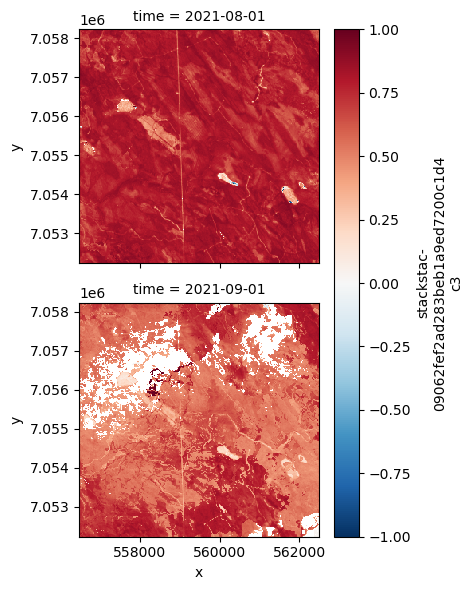

In [23]:
ndvi.plot(row="time")

Save the result to a file:
* `Rioxarray` currently supports writing only one dimension besides the x and y. We have both bands and time, so for saving we select only one month here.
* [For parallel writing with Dask](https://corteva.github.io/rioxarray/html/examples/dask_read_write.html#) use the Lock and `tiled`. 
* It is important to use absolute path for file name.

In [24]:
%%time
output_file = os.path.join(os.getcwd(), "ndvi.tif")
mean_ndvi_tiff = ndvi.isel(time=0).rio.to_raster(
    output_file,
    lock=Lock(name="rio"),
    tiled=True,
)

CPU times: user 43.5 ms, sys: 10.5 ms, total: 54 ms
Wall time: 1.06 s


Close Dask cluster, rest of this example does not benefit from Dask.

In [25]:
client.close()

## Other tools
It is possible to use the STAC also when working with rasterio or other tools, but then the URLs must be manually retrieved.

### One item info
See detailed info about one Item.

In [26]:
i = 0
item = item_collection[i]
print(f"{i}: {item}")
print(f"{i}: {item.bbox}")
print(f"{i}: {item.properties}")
print(f"Available assets: {item.assets.keys()}")
for key in item.assets.keys():
        print(f"{key}: {item.assets[key]}")

0: <Item id=Sentinel-2_global_mosaic_dekadi_2021-09-21_2021-09-30>
0: [15.201371, 59.14202, 36.021476, 70.077018]
0: {'start_datetime': '2021-09-21T00:00:00.000+00:00', 'end_datetime': '2021-09-30T23:59:59.000+00:00', 'datetime': '2021-09-21T00:00:00Z', 'gsd': 20.0, 'proj:transform': [20, 0, 50200, 0, -20, 7799840, 0, 0, 1], 'proj:code': 'EPSG:3067'}
Available assets: dict_keys(['medoid_mos', 'valid_obs', 'quality_scene_classification', 'quality_snow_confidence', 'quality_cloud_confidence', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b11', 'b12', 'view_azimuth_mean', 'sun_azimuth', 'view_zenith_mean', 'sun_zenith', 'source_index', 'quality_aot'])
medoid_mos: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_medoid_mos/s2m_sdr_20210921-20210930_medoid_mos_r20m.tif>
valid_obs: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_valid_obs/s2m_sdr_20210921-20210930_valid_obs_r20m.tif>
quality_scene_classification: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_quality_sce

## Working with rasterio or other tools

Rasterio is widely used Python package for raster data.

In [27]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window

Select item and asset, retrieve URL.

In [28]:
url = item_collection[3].assets['b02'].href
url

'https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20210821-20210831_b02_r20m.tif'

Open with rasterio, see basic info

In [29]:
%time
dataset = rasterio.open(url)
print(f"Transform: {dataset.transform}")
print(f"Transform: {dataset.shape}")
print(f"Transform: {dataset.crs}")

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 5.48 μs
Transform: | 20.00, 0.00, 50200.00|
| 0.00,-20.00, 7799840.00|
| 0.00, 0.00, 1.00|
Transform: (60869, 39590)
Transform: EPSG:3067


Plot with rasterio a small part of the image

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.01 μs


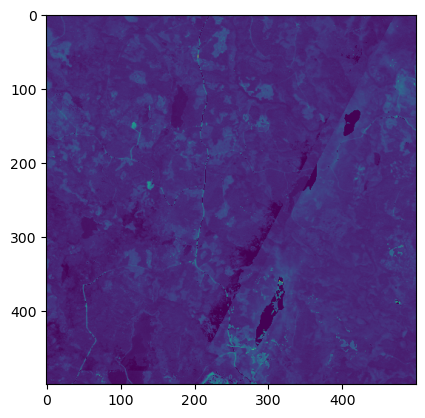

<Axes: >

In [30]:
%time
show(dataset.read(window=Window(20000, 20000, 500, 500)))

Use GDAL with the URL.

In [33]:
!gdalinfo /vsicurl/{url}

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20210821-20210831_b02_r20m.tif
Size is 39590, 60869
Coordinate System is:
PROJCRS["ETRS89 / TM35FIN(E,N)",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2

## Using Jupyter Dask extension

Jupyter has extension to see what Dask cluster is doing in more detail.

To make Jupyter Dask Extension to work nicely in Noppe (and Puhti), do not start the cluster from Python code.

* Open Jupyter Dask Extension from the left menu (the red squares)
* Click `New`
* Click `Scale`, during workshop set the number of workers to 2.
* Click `<>` to create code block to the Notebook
* Run the new cell.
* Open for example Workers, Worker CPU utilization, Task Stream and Workers Memory as visible graphs.
* Run the notebook again to see the graphs in action.

Once done, `Shutdown the cluster`.

If the Dask cluster is started from the code, it works fine for computing, but the Dask status graphs will not work.
